# BTC Crypto Extension: LSTM-Based Trading Strategy

## Project Overview

This notebook implements a **cross-market crypto extension** that:
1. **Collects and preprocesses** daily BTC-USD data via Yahoo Finance (yfinance)
2. **Engineers features** including lagged returns, rolling volatility, and volume metrics
3. **Trains an LSTM model** in PyTorch to predict next-day BTC returns
4. **Converts predictions** into allocation weights in [0, 2]
5. **Enforces volatility constraint**: strategy volatility ≤ 1.2 × benchmark volatility
6. **Backtests and computes metrics**: Sharpe ratio, cumulative returns, volatility ratio, max drawdown

### Target Market
- **Ticker**: BTC-USD (Bitcoin)
- **Frequency**: Daily
- **Data Source**: Yahoo Finance via `yfinance`

### Model Architecture
- **Type**: LSTM (Long Short-Term Memory)
- **Framework**: PyTorch
- **Sequence Length**: 20 days
- **Target**: Next-day log return

In [ ]:
# =============================================================================
# IMPORTS AND SETUP
# =============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Data source
import yfinance as yf

# PyTorch for LSTM model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Optional: scikit-learn utilities
from sklearn.preprocessing import StandardScaler

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if GPU is available (MPS for MAC, CUDA for NVIDIA, else CPU)
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

print("All libraries imported successfully!")

Using device: mps
All libraries imported successfully!


In [83]:
# =============================================================================
# PATH SETUP - Create necessary directories
# =============================================================================

# Define base paths (relative to notebook location)
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
DATA_DIR = os.path.join(BASE_DIR, '..', 'data')
REPORTS_DIR = os.path.join(BASE_DIR, '..', 'reports')

# Create directories if they don't exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

# Define file paths
RAW_DATA_PATH = os.path.join(DATA_DIR, 'btc_raw.csv')
DAILY_DATA_PATH = os.path.join(DATA_DIR, 'btc_daily.csv')
FEATURES_DATA_PATH = os.path.join(DATA_DIR, 'btc_features.csv')

# Report paths
CUM_RETURNS_PLOT_PATH = os.path.join(REPORTS_DIR, 'cum_returns.png')
WEIGHTS_PLOT_PATH = os.path.join(REPORTS_DIR, 'weights.png')

print("Directory structure:")
print(f"  Data directory: {os.path.abspath(DATA_DIR)}")
print(f"  Reports directory: {os.path.abspath(REPORTS_DIR)}")
print("\nFile paths configured:")
print(f"  Raw data: {RAW_DATA_PATH}")
print(f"  Daily data: {DAILY_DATA_PATH}")
print(f"  Features data: {FEATURES_DATA_PATH}")
print("\nDirectories created successfully!")

Directory structure:
  Data directory: /Users/erikp/Documents/vscode/HullTactical/HullTactical/extension/data
  Reports directory: /Users/erikp/Documents/vscode/HullTactical/HullTactical/extension/reports

File paths configured:
  Raw data: /Users/erikp/Documents/vscode/HullTactical/HullTactical/extension/notebooks/../data/btc_raw.csv
  Daily data: /Users/erikp/Documents/vscode/HullTactical/HullTactical/extension/notebooks/../data/btc_daily.csv
  Features data: /Users/erikp/Documents/vscode/HullTactical/HullTactical/extension/notebooks/../data/btc_features.csv

Directories created successfully!


## Configuration Constants

Define all hyperparameters and configuration values used throughout the notebook.

In [84]:
# =============================================================================
# CONFIGURATION CONSTANTS
# =============================================================================

# Data configuration
TICKER = "BTC-USD"
START_DATE = "2015-01-01"
END_DATE = datetime.today().strftime('%Y-%m-%d')  # Today's date
INTERVAL = "1d"

# Feature engineering parameters
LAG_DAYS = list(range(1, 11))  # ret_lag_1 to ret_lag_10
ROLLING_WINDOW = 7  # For volatility, mean return, and moving average

# Train/Val/Test split ratios (by time)
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# LSTM Model hyperparameters
SEQ_LEN = 20           # Sequence length (lookback window)
HIDDEN_SIZE = 64       # LSTM hidden size
NUM_LAYERS = 1         # Number of LSTM layers
DROPOUT = 0.0          # Dropout rate

# Training hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
PATIENCE = 5           # Early stopping patience

# Strategy parameters
THRESHOLD_HIGH = 0.005  # 0.5% predicted return threshold for max allocation (lowered for more participation)
VOL_CONSTRAINT = 1.5   # Strategy vol <= 1.5 * benchmark vol (relaxed constraint)

print("Configuration loaded:")
print(f"  Ticker: {TICKER}")
print(f"  Date range: {START_DATE} to {END_DATE}")
print(f"  Sequence length: {SEQ_LEN}")
print(f"  LSTM hidden size: {HIDDEN_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Volatility constraint: {VOL_CONSTRAINT}x benchmark")

Configuration loaded:
  Ticker: BTC-USD
  Date range: 2015-01-01 to 2025-12-04
  Sequence length: 20
  LSTM hidden size: 64
  Batch size: 64
  Epochs: 30
  Volatility constraint: 1.5x benchmark


---
## Step 2: Data Download and Preprocessing

Download BTC-USD daily data from Yahoo Finance using yfinance, then clean and compute log returns.

In [85]:
# =============================================================================
# DOWNLOAD RAW BTC DATA FROM YAHOO FINANCE
# =============================================================================

print(f"Downloading {TICKER} data from Yahoo Finance...")
print(f"Date range: {START_DATE} to {END_DATE}")
print(f"Interval: {INTERVAL}")

# Download BTC-USD data using yfinance
btc_raw = yf.download(TICKER, start=START_DATE, end=END_DATE, interval=INTERVAL)

# Display basic info
print(f"\nDownload complete!")
print(f"Raw data shape: {btc_raw.shape}")
print(f"Date range: {btc_raw.index.min()} to {btc_raw.index.max()}")
print(f"\nColumns: {list(btc_raw.columns)}")

# Save raw data to CSV
btc_raw.to_csv(RAW_DATA_PATH)
print(f"\nRaw data saved to: {RAW_DATA_PATH}")

# Display first few rows
btc_raw.head()

Date range: 2015-01-01 to 2025-12-04
Interval: 1d


[*********************100%***********************]  1 of 1 completed


Download complete!
Raw data shape: (3990, 5)
Date range: 2015-01-01 00:00:00 to 2025-12-03 00:00:00

Columns: [('Close', 'BTC-USD'), ('High', 'BTC-USD'), ('Low', 'BTC-USD'), ('Open', 'BTC-USD'), ('Volume', 'BTC-USD')]

Raw data saved to: /Users/erikp/Documents/vscode/HullTactical/HullTactical/extension/notebooks/../data/btc_raw.csv


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800


In [86]:
# =============================================================================
# CLEAN AND PREPROCESS DATA -> btc_daily.csv
# =============================================================================

# Load raw data - handle new yfinance CSV format with multi-row headers
# New format has: Row 1 = column names, Row 2 = ticker symbols, Row 3 = "Date" label
# We need to skip rows 1-2 (0-indexed: rows 1,2) and use row 0 as header

# First, peek at the file to detect format
with open(RAW_DATA_PATH, 'r') as f:
    first_lines = [f.readline() for _ in range(4)]
    
print("First 4 lines of raw CSV:")
for i, line in enumerate(first_lines):
    print(f"  Line {i}: {line.strip()[:80]}")

# Check if this is the new yfinance format (has "Ticker" in second row)
if 'Ticker' in first_lines[1]:
    print("\nDetected NEW yfinance CSV format (with Ticker row)")
    # Skip the Ticker and Date label rows (rows 1 and 2, 0-indexed)
    df = pd.read_csv(RAW_DATA_PATH, skiprows=[1, 2])
    # First column 'Price' contains the dates
    df = df.rename(columns={'Price': 'date'})
else:
    print("\nDetected standard CSV format")
    df = pd.read_csv(RAW_DATA_PATH)
    # Handle standard format column naming
    if 'Date' in df.columns:
        df = df.rename(columns={'Date': 'date'})
    elif df.index.name == 'Date':
        df = df.reset_index()
        df = df.rename(columns={'Date': 'date'})

print(f"\nColumns after loading: {list(df.columns)}")
print(f"First 3 rows:")
print(df.head(3))

# Standardize column names (handle various formats)
rename_map = {}
for col in df.columns:
    col_lower = col.lower().replace(' ', '_')
    if col_lower == 'date':
        continue  # Already named correctly
    elif 'open' in col_lower:
        rename_map[col] = 'open'
    elif 'high' in col_lower:
        rename_map[col] = 'high'
    elif 'low' in col_lower:
        rename_map[col] = 'low'
    elif 'adj' in col_lower and 'close' in col_lower:
        rename_map[col] = 'adj_close'
    elif 'close' in col_lower:
        rename_map[col] = 'close'
    elif 'volume' in col_lower:
        rename_map[col] = 'volume'

df = df.rename(columns=rename_map)

print(f"\nAfter renaming columns: {list(df.columns)}")

# Ensure date column exists and convert to datetime
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date']).dt.normalize()
else:
    raise ValueError(f"Could not find date column. Available columns: {list(df.columns)}")

# Sort by date ascending
df = df.sort_values('date').reset_index(drop=True)

# Drop duplicated dates (keep first)
df = df.drop_duplicates(subset='date', keep='first')

print(f"\nAfter cleaning: {len(df)} rows")
print(f"Final columns: {list(df.columns)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
df.head()

First 4 lines of raw CSV:
  Line 0: Price,Close,High,Low,Open,Volume
  Line 1: Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
  Line 2: Date,,,,,
  Line 3: 2015-01-01,314.2489929199219,320.43499755859375,314.00299072265625,320.434997558

Detected NEW yfinance CSV format (with Ticker row)

Columns after loading: ['date', 'Close', 'High', 'Low', 'Open', 'Volume']
First 3 rows:
         date       Close        High         Low        Open    Volume
0  2015-01-01  314.248993  320.434998  314.002991  320.434998   8036550
1  2015-01-02  315.032013  315.838989  313.565002  314.079010   7860650
2  2015-01-03  281.082001  315.149994  281.082001  314.846008  33054400

After renaming columns: ['date', 'close', 'high', 'low', 'open', 'volume']

After cleaning: 3990 rows
Final columns: ['date', 'close', 'high', 'low', 'open', 'volume']
Date range: 2015-01-01 00:00:00 to 2025-12-03 00:00:00


,date,close,high,low,open,volume
0,2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550
1,2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650
2,2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400
3,2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100
4,2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800


In [87]:
# =============================================================================
# COMPUTE DAILY LOG RETURNS
# =============================================================================

# Compute daily log return: ret_t = log(close_t / close_{t-1})
df['ret'] = np.log(df['close'] / df['close'].shift(1))

# First row will have NaN in ret - drop it
df = df.dropna(subset=['ret'])

# Drop any remaining rows with NaN in ret
df = df.dropna(subset=['ret'])

# Reset index after dropping rows
df = df.reset_index(drop=True)

# Ensure columns are in the correct order
final_columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'ret']
# Only keep columns that exist
final_columns = [c for c in final_columns if c in df.columns]
df = df[final_columns]

# Save cleaned daily data
df.to_csv(DAILY_DATA_PATH, index=False)

print("=" * 60)
print("CLEANED DAILY DATA SUMMARY (btc_daily.csv)")
print("=" * 60)
print(f"Shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total trading days: {len(df)}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nReturn statistics:")
print(f"  Mean daily return: {df['ret'].mean():.6f}")
print(f"  Std daily return: {df['ret'].std():.6f}")
print(f"  Min return: {df['ret'].min():.4f}")
print(f"  Max return: {df['ret'].max():.4f}")
print(f"\nSaved to: {DAILY_DATA_PATH}")

df.head(10)

CLEANED DAILY DATA SUMMARY (btc_daily.csv)
Shape: (3989, 7)
Date range: 2015-01-02 00:00:00 to 2025-12-03 00:00:00
Total trading days: 3989

Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'ret']

Return statistics:
  Mean daily return: 0.001427
  Std daily return: 0.035566
  Min return: -0.4647
  Max return: 0.2251

Saved to: /Users/erikp/Documents/vscode/HullTactical/HullTactical/extension/notebooks/../data/btc_daily.csv


,date,open,high,low,close,volume,ret
0,2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650,0.002489
1,2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400,-0.114028
2,2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100,-0.061959
3,2015-01-05,265.084015,278.341003,265.084015,274.473999,43962800,0.038169
4,2015-01-06,274.610992,287.553009,272.696014,286.188995,23245700,0.041796
5,2015-01-07,286.076996,298.753998,283.079010,294.337006,24866800,0.028073
6,2015-01-08,294.135010,294.135010,282.174988,283.348999,19982500,-0.038046
7,2015-01-09,282.382996,291.114014,280.532990,290.407990,18718600,0.024607
8,2015-01-10,287.303009,288.127014,273.966003,274.795990,15264300,-0.055258
9,2015-01-11,274.608002,279.638000,265.039001,265.660004,18200800,-0.033812


### Data Quality Check

Verify the cleaned dataset has no missing values and the log returns are correctly computed.

In [88]:
# =============================================================================
# DATA QUALITY CHECK
# =============================================================================

print("Data Quality Check")
print("=" * 60)

# Check for missing values
missing = df.isnull().sum()
print("\nMissing values per column:")
print(missing)

# Verify no NaN in ret column
assert df['ret'].isna().sum() == 0, "ERROR: NaN values found in 'ret' column!"
print("\n✓ No missing values in 'ret' column")

# Verify log return calculation (spot check)
# ret_t should equal log(close_t / close_{t-1})
sample_idx = 5
expected_ret = np.log(df.loc[sample_idx, 'close'] / df.loc[sample_idx - 1, 'close'])
actual_ret = df.loc[sample_idx, 'ret']
assert np.isclose(expected_ret, actual_ret), f"Log return mismatch at index {sample_idx}"
print(f"✓ Log return calculation verified (sample check passed)")

# Check date continuity (should be roughly daily, with weekends/holidays)
date_diffs = df['date'].diff().dt.days.dropna()
print(f"\n✓ Date differences: min={date_diffs.min()}, max={date_diffs.max()}, mean={date_diffs.mean():.2f}")

print("\n" + "=" * 60)
print("DATA QUALITY CHECK PASSED")
print("=" * 60)

Data Quality Check

Missing values per column:
date      0
open      0
high      0
low       0
close     0
volume    0
ret       0
dtype: int64

✓ No missing values in 'ret' column
✓ Log return calculation verified (sample check passed)

✓ Date differences: min=1.0, max=1.0, mean=1.00

DATA QUALITY CHECK PASSED


---
## Step 3: Feature Engineering

Create additional features from the cleaned daily data:
- **Lagged returns**: `ret_lag_1` to `ret_lag_10` (return shifted by k days)
- **Rolling volatility**: `vol_7` (7-day rolling std of returns)
- **Rolling mean return**: `mean_ret_7` (7-day rolling mean of returns)
- **Moving average price**: `ma_close_7` (7-day rolling mean of close price)
- **Volume feature**: `log_volume` (log(1 + volume))

In [89]:
# =============================================================================
# LOAD CLEANED DAILY DATA
# =============================================================================

# Load the cleaned daily data
df_daily = pd.read_csv(DAILY_DATA_PATH)
df_daily['date'] = pd.to_datetime(df_daily['date'])

print(f"Loaded btc_daily.csv: {df_daily.shape}")
print(f"Date range: {df_daily['date'].min()} to {df_daily['date'].max()}")
df_daily.head()

Loaded btc_daily.csv: (3989, 7)
Date range: 2015-01-02 00:00:00 to 2025-12-03 00:00:00


,date,open,high,low,close,volume,ret
0,2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650,0.002489
1,2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400,-0.114028
2,2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100,-0.061959
3,2015-01-05,265.084015,278.341003,265.084015,274.473999,43962800,0.038169
4,2015-01-06,274.610992,287.553009,272.696014,286.188995,23245700,0.041796


In [90]:
# =============================================================================
# FEATURE ENGINEERING
# =============================================================================

df_features = df_daily.copy()

# -----------------------------------------------------------------------------
# 1. Lagged Returns: ret_lag_1, ret_lag_2, ..., ret_lag_10
# -----------------------------------------------------------------------------
print("Creating lagged return features...")
for lag in LAG_DAYS:  # LAG_DAYS = [1, 2, 3, ..., 10]
    df_features[f'ret_lag_{lag}'] = df_features['ret'].shift(lag)

print(f"  Created {len(LAG_DAYS)} lagged return features: ret_lag_1 to ret_lag_{max(LAG_DAYS)}")

# -----------------------------------------------------------------------------
# 2. Rolling Volatility: vol_7 (7-day rolling std of returns)
# -----------------------------------------------------------------------------
print("Creating rolling volatility feature...")
df_features['vol_7'] = df_features['ret'].rolling(window=ROLLING_WINDOW).std()
print(f"  Created vol_7 (rolling std over {ROLLING_WINDOW} days)")

# -----------------------------------------------------------------------------
# 3. Rolling Mean Return: mean_ret_7 (7-day rolling mean of returns)
# -----------------------------------------------------------------------------
print("Creating rolling mean return feature...")
df_features['mean_ret_7'] = df_features['ret'].rolling(window=ROLLING_WINDOW).mean()
print(f"  Created mean_ret_7 (rolling mean over {ROLLING_WINDOW} days)")

# -----------------------------------------------------------------------------
# 4. Moving Average Price: ma_close_7 (7-day rolling mean of close price)
# -----------------------------------------------------------------------------
print("Creating moving average close price feature...")
df_features['ma_close_7'] = df_features['close'].rolling(window=ROLLING_WINDOW).mean()
print(f"  Created ma_close_7 (rolling mean of close over {ROLLING_WINDOW} days)")

# -----------------------------------------------------------------------------
# 5. Volume Feature: log_volume = log(1 + volume)
# -----------------------------------------------------------------------------
print("Creating log volume feature...")
df_features['log_volume'] = np.log1p(df_features['volume'])  # log(1 + volume)
print("  Created log_volume = log(1 + volume)")

print(f"\nTotal features created: {len(df_features.columns) - len(df_daily.columns)}")
print(f"DataFrame shape before dropping NaNs: {df_features.shape}")

Creating lagged return features...
  Created 10 lagged return features: ret_lag_1 to ret_lag_10
Creating rolling volatility feature...
  Created vol_7 (rolling std over 7 days)
Creating rolling mean return feature...
  Created mean_ret_7 (rolling mean over 7 days)
Creating moving average close price feature...
  Created ma_close_7 (rolling mean of close over 7 days)
Creating log volume feature...
  Created log_volume = log(1 + volume)

Total features created: 14
DataFrame shape before dropping NaNs: (3989, 21)


In [91]:
# =============================================================================
# DROP ROWS WITH NaN AND SAVE FEATURES DATASET
# =============================================================================

# Count NaN rows before dropping
nan_rows_before = df_features.isna().any(axis=1).sum()
print(f"Rows with NaN values (initial rolling window rows): {nan_rows_before}")

# Drop rows with any NaN values (these are initial rows from rolling/lag operations)
df_features = df_features.dropna()
df_features = df_features.reset_index(drop=True)

# Save to btc_features.csv
df_features.to_csv(FEATURES_DATA_PATH, index=False)

print(f"\nFeatures dataset saved to: {FEATURES_DATA_PATH}")
print(f"Final shape: {df_features.shape}")
print(f"Date range: {df_features['date'].min()} to {df_features['date'].max()}")

Rows with NaN values (initial rolling window rows): 10

Features dataset saved to: /Users/erikp/Documents/vscode/HullTactical/HullTactical/extension/notebooks/../data/btc_features.csv
Final shape: (3979, 21)
Date range: 2015-01-12 00:00:00 to 2025-12-03 00:00:00


### Feature Summary

Display the final feature dataset structure and statistics.

In [92]:
# =============================================================================
# FEATURE SUMMARY
# =============================================================================

print("=" * 70)
print("FEATURE DATASET SUMMARY (btc_features.csv)")
print("=" * 70)

# List all columns
print("\nAll columns:")
for i, col in enumerate(df_features.columns):
    print(f"  {i+1:2d}. {col}")

# Separate feature columns from metadata
metadata_cols = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'ret']
feature_cols = [c for c in df_features.columns if c not in metadata_cols]

print(f"\n" + "-" * 70)
print(f"Feature columns for model input ({len(feature_cols)} features):")
print("-" * 70)
for col in feature_cols:
    print(f"  - {col}")

print(f"\n" + "-" * 70)
print("Feature Statistics:")
print("-" * 70)
print(df_features[feature_cols].describe().T)

# Check for any remaining NaN
print(f"\n" + "-" * 70)
print("Missing values check:")
print("-" * 70)
print(df_features.isna().sum())

print("\n" + "=" * 70)
print("FEATURE ENGINEERING COMPLETE")
print("=" * 70)

# Display first few rows of features
df_features.head()

FEATURE DATASET SUMMARY (btc_features.csv)

All columns:
   1. date
   2. open
   3. high
   4. low
   5. close
   6. volume
   7. ret
   8. ret_lag_1
   9. ret_lag_2
  10. ret_lag_3
  11. ret_lag_4
  12. ret_lag_5
  13. ret_lag_6
  14. ret_lag_7
  15. ret_lag_8
  16. ret_lag_9
  17. ret_lag_10
  18. vol_7
  19. mean_ret_7
  20. ma_close_7
  21. log_volume

----------------------------------------------------------------------
Feature columns for model input (14 features):
----------------------------------------------------------------------
  - ret_lag_1
  - ret_lag_2
  - ret_lag_3
  - ret_lag_4
  - ret_lag_5
  - ret_lag_6
  - ret_lag_7
  - ret_lag_8
  - ret_lag_9
  - ret_lag_10
  - vol_7
  - mean_ret_7
  - ma_close_7
  - log_volume

----------------------------------------------------------------------
Feature Statistics:
----------------------------------------------------------------------
             count          mean           std         min          25%  \
ret_lag_1   3979.

,date,open,high,low,close,volume,ret,ret_lag_1,ret_lag_2,ret_lag_3,...,ret_lag_5,ret_lag_6,ret_lag_7,ret_lag_8,ret_lag_9,ret_lag_10,vol_7,mean_ret_7,ma_close_7,log_volume
0,2015-01-12,266.145996,272.203003,265.200012,267.795990,18880300,0.008008,-0.033812,-0.055258,0.024607,...,0.028073,0.041796,0.038169,-0.061959,-0.114028,0.002489,0.038215,-0.003519,280.362139,16.753630
1,2015-01-13,267.394012,268.277008,219.906006,225.860992,72843904,-0.170306,0.008008,-0.033812,-0.055258,...,-0.038046,0.028073,0.041796,0.038169,-0.061959,-0.114028,0.068435,-0.033819,271.743853,18.103829
2,2015-01-14,223.893997,223.893997,171.509995,178.102997,97638704,-0.237558,-0.170306,0.008008,-0.033812,...,0.024607,-0.038046,0.028073,0.041796,0.038169,-0.061959,0.096349,-0.071766,255.138994,18.396785
3,2015-01-15,176.897003,229.067001,176.897003,209.843994,81773504,0.164002,-0.237558,-0.170306,0.008008,...,-0.055258,0.024607,-0.038046,0.028073,0.041796,0.038169,0.131856,-0.042902,244.638280,18.219464
4,2015-01-16,209.070007,221.591003,199.770996,208.097000,38421000,-0.008360,0.164002,-0.237558,-0.170306,...,-0.033812,-0.055258,0.024607,-0.038046,0.028073,0.041796,0.129613,-0.047612,232.879567,17.464115


---
## Step 4: Train/Val/Test Split, Normalization, and Dataset Creation

Split the data chronologically (no shuffling for time series):
- **Train**: First 70% of data
- **Validation**: Next 15% of data  
- **Test**: Last 15% of data

Then normalize features using train set statistics and create PyTorch Dataset/DataLoader objects.

In [93]:
# =============================================================================
# LOAD FEATURES AND PERFORM TIME-BASED SPLIT
# =============================================================================

# Load the feature dataset
df_features = pd.read_csv(FEATURES_DATA_PATH)
df_features['date'] = pd.to_datetime(df_features['date'])

# Sort by date (should already be sorted, but ensure)
df_features = df_features.sort_values('date').reset_index(drop=True)

# Calculate split indices
n_samples = len(df_features)
train_end = int(n_samples * TRAIN_RATIO)
val_end = int(n_samples * (TRAIN_RATIO + VAL_RATIO))

# Split the data chronologically (NO SHUFFLING)
df_train = df_features.iloc[:train_end].copy()
df_val = df_features.iloc[train_end:val_end].copy()
df_test = df_features.iloc[val_end:].copy()

print("=" * 60)
print("TIME-BASED DATA SPLIT")
print("=" * 60)
print(f"\nTotal samples: {n_samples}")
print(f"\nTrain set: {len(df_train)} samples ({len(df_train)/n_samples*100:.1f}%)")
print(f"  Date range: {df_train['date'].min()} to {df_train['date'].max()}")
print(f"\nValidation set: {len(df_val)} samples ({len(df_val)/n_samples*100:.1f}%)")
print(f"  Date range: {df_val['date'].min()} to {df_val['date'].max()}")
print(f"\nTest set: {len(df_test)} samples ({len(df_test)/n_samples*100:.1f}%)")
print(f"  Date range: {df_test['date'].min()} to {df_test['date'].max()}")

TIME-BASED DATA SPLIT

Total samples: 3979

Train set: 2785 samples (70.0%)
  Date range: 2015-01-12 00:00:00 to 2022-08-27 00:00:00

Validation set: 597 samples (15.0%)
  Date range: 2022-08-28 00:00:00 to 2024-04-15 00:00:00

Test set: 597 samples (15.0%)
  Date range: 2024-04-16 00:00:00 to 2025-12-03 00:00:00


In [94]:
# =============================================================================
# DEFINE FEATURE AND TARGET COLUMNS
# =============================================================================

# Feature columns: all engineered numeric columns EXCEPT date and ret (target)
EXCLUDE_COLS = ['date', 'ret', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
FEATURE_COLS = [c for c in df_features.columns if c not in EXCLUDE_COLS]

# Target column
TARGET_COL = 'ret'

print("Feature columns for model input:")
print("-" * 40)
for i, col in enumerate(FEATURE_COLS):
    print(f"  {i+1:2d}. {col}")

print(f"\nTotal features: {len(FEATURE_COLS)}")
print(f"Target column: {TARGET_COL}")

Feature columns for model input:
----------------------------------------
   1. ret_lag_1
   2. ret_lag_2
   3. ret_lag_3
   4. ret_lag_4
   5. ret_lag_5
   6. ret_lag_6
   7. ret_lag_7
   8. ret_lag_8
   9. ret_lag_9
  10. ret_lag_10
  11. vol_7
  12. mean_ret_7
  13. ma_close_7
  14. log_volume

Total features: 14
Target column: ret


In [95]:
# =============================================================================
# NORMALIZE FEATURES USING TRAIN SET STATISTICS
# =============================================================================

# Extract feature arrays
X_train_raw = df_train[FEATURE_COLS].values
X_val_raw = df_val[FEATURE_COLS].values
X_test_raw = df_test[FEATURE_COLS].values

# Compute mean and std from TRAIN set only
train_mean = X_train_raw.mean(axis=0)
train_std = X_train_raw.std(axis=0)

# Avoid division by zero (replace zero std with 1)
train_std[train_std == 0] = 1.0

# Normalize all sets using train statistics
X_train_norm = (X_train_raw - train_mean) / train_std
X_val_norm = (X_val_raw - train_mean) / train_std
X_test_norm = (X_test_raw - train_mean) / train_std

# Extract target arrays (no normalization for target)
y_train = df_train[TARGET_COL].values
y_val = df_val[TARGET_COL].values
y_test = df_test[TARGET_COL].values

# Store normalization stats for later use in backtest
norm_stats = {
    'mean': train_mean,
    'std': train_std,
    'feature_cols': FEATURE_COLS
}

print("=" * 60)
print("FEATURE NORMALIZATION")
print("=" * 60)
print(f"\nNormalization computed from TRAIN set only")
print(f"Train mean range: [{train_mean.min():.6f}, {train_mean.max():.6f}]")
print(f"Train std range: [{train_std.min():.6f}, {train_std.max():.6f}]")
print(f"\nNormalized shapes:")
print(f"  X_train: {X_train_norm.shape}")
print(f"  X_val: {X_val_norm.shape}")
print(f"  X_test: {X_test_norm.shape}")
print(f"\nTarget shapes:")
print(f"  y_train: {y_train.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  y_test: {y_test.shape}")

FEATURE NORMALIZATION

Normalization computed from TRAIN set only
Train mean range: [0.001541, 13108.406973]
Train std range: [0.015000, 16609.139937]

Normalized shapes:
  X_train: (2785, 14)
  X_val: (597, 14)
  X_test: (597, 14)

Target shapes:
  y_train: (2785,)
  y_val: (597,)
  y_test: (597,)


In [96]:
# =============================================================================
# PYTORCH DATASET CLASS FOR TIME SERIES
# =============================================================================

class TimeSeriesDataset(Dataset):
    """
    PyTorch Dataset for time series sequence data.
    
    For a sequence starting at index i:
    - Input X_i: features for days [i, i+1, ..., i+seq_len-1]
    - Target y_i: 'ret' at day (i + seq_len)
    
    Args:
        features: Normalized feature array (n_samples, n_features)
        targets: Target array (n_samples,)
        seq_len: Sequence length (lookback window)
    """
    
    def __init__(self, features, targets, seq_len):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
        self.seq_len = seq_len
        
    def __len__(self):
        # Number of valid sequences
        # We need seq_len days for input and 1 more day for target
        return len(self.features) - self.seq_len
    
    def __getitem__(self, idx):
        # Input: features from idx to idx+seq_len-1
        X = self.features[idx:idx + self.seq_len]
        
        # Target: return at idx+seq_len (next day after the sequence)
        y = self.targets[idx + self.seq_len]
        
        return X, y

print("TimeSeriesDataset class defined")
print(f"  Sequence length: {SEQ_LEN}")
print(f"  Input shape per sample: ({SEQ_LEN}, {len(FEATURE_COLS)})")
print(f"  Output: scalar (next day return)")

TimeSeriesDataset class defined
  Sequence length: 20
  Input shape per sample: (20, 14)
  Output: scalar (next day return)


In [97]:
# =============================================================================
# CREATE DATASETS AND DATALOADERS
# =============================================================================

# Create Dataset objects
train_dataset = TimeSeriesDataset(X_train_norm, y_train, SEQ_LEN)
val_dataset = TimeSeriesDataset(X_val_norm, y_val, SEQ_LEN)
test_dataset = TimeSeriesDataset(X_test_norm, y_test, SEQ_LEN)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("=" * 60)
print("PYTORCH DATASETS AND DATALOADERS")
print("=" * 60)
print(f"\nDataset sizes (after sequence windowing):")
print(f"  Train dataset: {len(train_dataset)} sequences")
print(f"  Val dataset: {len(val_dataset)} sequences")
print(f"  Test dataset: {len(test_dataset)} sequences")
print(f"\nDataLoader configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Verify a sample batch
sample_X, sample_y = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"  X shape: {sample_X.shape}  (batch, seq_len, features)")
print(f"  y shape: {sample_y.shape}  (batch,)")

PYTORCH DATASETS AND DATALOADERS

Dataset sizes (after sequence windowing):
  Train dataset: 2765 sequences
  Val dataset: 577 sequences
  Test dataset: 577 sequences

DataLoader configuration:
  Batch size: 64
  Train batches: 44
  Val batches: 10
  Test batches: 10

Sample batch shapes:
  X shape: torch.Size([64, 20, 14])  (batch, seq_len, features)
  y shape: torch.Size([64])  (batch,)


In [98]:
# =============================================================================
# STORE METADATA FOR BACKTEST (dates and actual returns)
# =============================================================================

# We need to align dates with the sequences
# For sequence starting at index i, target is at index i + SEQ_LEN
# So valid dates for test set predictions start at SEQ_LEN offset

test_dates = df_test['date'].values[SEQ_LEN:]
test_actual_returns = df_test[TARGET_COL].values[SEQ_LEN:]

print("Test set metadata for backtesting:")
print(f"  Number of prediction days: {len(test_dates)}")
print(f"  Date range: {test_dates[0]} to {test_dates[-1]}")
print(f"  Actual returns shape: {test_actual_returns.shape}")

# Store for later use
backtest_metadata = {
    'dates': test_dates,
    'actual_returns': test_actual_returns,
    'df_test': df_test
}

print("\n" + "=" * 60)
print("STEP 4 COMPLETE: Data ready for model training")
print("=" * 60)

Test set metadata for backtesting:
  Number of prediction days: 577
  Date range: 2024-05-06T00:00:00.000000000 to 2025-12-03T00:00:00.000000000
  Actual returns shape: (577,)

STEP 4 COMPLETE: Data ready for model training


---
## Step 5: Define and Train LSTM Model

Build a PyTorch LSTM model to predict next-day BTC returns:
- **Architecture**: LSTM with hidden_size=64, num_layers=1
- **Output**: Single scalar (predicted return)
- **Optimizer**: Adam with lr=0.001
- **Loss**: MSELoss
- **Early Stopping**: Patience=5 epochs on validation loss

In [99]:
# =============================================================================
# DEFINE LSTM MODEL ARCHITECTURE
# =============================================================================

class BtcLSTMModel(nn.Module):
    """
    LSTM model for predicting next-day BTC returns.
    
    Architecture:
        - LSTM layer(s) to process sequential data
        - Fully connected layer to output scalar prediction
    
    Args:
        input_size: Number of features per timestep
        hidden_size: LSTM hidden state dimension
        num_layers: Number of stacked LSTM layers
        dropout: Dropout rate between LSTM layers (only if num_layers > 1)
    """
    
    def __init__(self, input_size, hidden_size=64, num_layers=1, dropout=0.0):
        super(BtcLSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,  # Input shape: (batch, seq_len, features)
            dropout=dropout if num_layers > 1 else 0.0
        )
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch, seq_len, input_size)
            
        Returns:
            Predicted return of shape (batch,)
        """
        # LSTM forward pass
        # lstm_out shape: (batch, seq_len, hidden_size)
        # h_n shape: (num_layers, batch, hidden_size)
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Use the last hidden state from the final layer
        # h_n[-1] shape: (batch, hidden_size)
        last_hidden = h_n[-1]
        
        # Output layer
        out = self.fc(last_hidden)  # Shape: (batch, 1)
        
        return out.squeeze(-1)  # Shape: (batch,)

# Instantiate model
num_features = len(FEATURE_COLS)
model = BtcLSTMModel(
    input_size=num_features,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

print("=" * 60)
print("LSTM MODEL ARCHITECTURE")
print("=" * 60)
print(f"\nModel configuration:")
print(f"  Input size: {num_features} features")
print(f"  Sequence length: {SEQ_LEN}")
print(f"  Hidden size: {HIDDEN_SIZE}")
print(f"  Num layers: {NUM_LAYERS}")
print(f"  Dropout: {DROPOUT}")
print(f"  Device: {device}")
print(f"\nModel structure:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

LSTM MODEL ARCHITECTURE

Model configuration:
  Input size: 14 features
  Sequence length: 20
  Hidden size: 64
  Num layers: 1
  Dropout: 0.0
  Device: mps

Model structure:
BtcLSTMModel(
  (lstm): LSTM(14, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Total parameters: 20,545
Trainable parameters: 20,545


In [100]:
# =============================================================================
# DEFINE TRAINING FUNCTIONS
# =============================================================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch and return average loss."""
    model.train()
    total_loss = 0.0
    n_batches = 0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / n_batches


def validate_epoch(model, val_loader, criterion, device):
    """Validate and return average loss."""
    model.eval()
    total_loss = 0.0
    n_batches = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            
            total_loss += loss.item()
            n_batches += 1
    
    return total_loss / n_batches

print("Training functions defined")

Training functions defined


In [101]:
# =============================================================================
# TRAINING LOOP WITH EARLY STOPPING
# =============================================================================

# Setup optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

# Training history
train_losses = []
val_losses = []

# Early stopping variables
best_val_loss = float('inf')
best_model_state = None
patience_counter = 0

print("=" * 60)
print("TRAINING LSTM MODEL")
print("=" * 60)
print(f"\nHyperparameters:")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {NUM_EPOCHS}")
print(f"  Early stopping patience: {PATIENCE}")
print(f"\nStarting training...\n")

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    # Print progress
    print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}", end="")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(" *")  # Mark best epoch
    else:
        patience_counter += 1
        print()
        
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nBest model restored (Val Loss: {best_val_loss:.6f})")

print("\nTraining complete!")

TRAINING LSTM MODEL

Hyperparameters:
  Learning rate: 0.001
  Batch size: 64
  Max epochs: 30
  Early stopping patience: 5

Starting training...

Epoch   1/30 | Train Loss: 0.002476 | Val Loss: 0.000648 *
Epoch   1/30 | Train Loss: 0.002476 | Val Loss: 0.000648 *
Epoch   2/30 | Train Loss: 0.001524 | Val Loss: 0.000675
Epoch   2/30 | Train Loss: 0.001524 | Val Loss: 0.000675
Epoch   3/30 | Train Loss: 0.001500 | Val Loss: 0.000837
Epoch   3/30 | Train Loss: 0.001500 | Val Loss: 0.000837
Epoch   4/30 | Train Loss: 0.001522 | Val Loss: 0.000642 *
Epoch   4/30 | Train Loss: 0.001522 | Val Loss: 0.000642 *
Epoch   5/30 | Train Loss: 0.001489 | Val Loss: 0.000633 *
Epoch   5/30 | Train Loss: 0.001489 | Val Loss: 0.000633 *
Epoch   6/30 | Train Loss: 0.001458 | Val Loss: 0.000648
Epoch   6/30 | Train Loss: 0.001458 | Val Loss: 0.000648
Epoch   7/30 | Train Loss: 0.001435 | Val Loss: 0.000731
Epoch   7/30 | Train Loss: 0.001435 | Val Loss: 0.000731
Epoch   8/30 | Train Loss: 0.001428 | Val L

### Training and Validation Loss Curves

Visualize the loss evolution during training to assess model convergence.

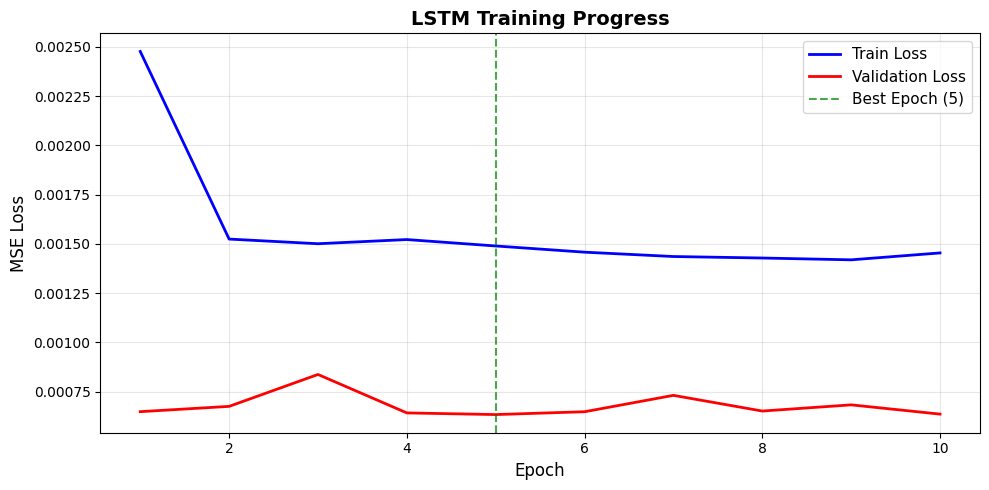


Training Summary:
  Total epochs trained: 10
  Best epoch: 5
  Best validation loss: 0.000633
  Final train loss: 0.001454


In [102]:
# =============================================================================
# PLOT TRAINING HISTORY
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 5))

epochs_range = range(1, len(train_losses) + 1)
ax.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2)
ax.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)

# Mark best epoch
best_epoch = val_losses.index(min(val_losses)) + 1
ax.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('MSE Loss', fontsize=12)
ax.set_title('LSTM Training Progress', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTraining Summary:")
print(f"  Total epochs trained: {len(train_losses)}")
print(f"  Best epoch: {best_epoch}")
print(f"  Best validation loss: {best_val_loss:.6f}")
print(f"  Final train loss: {train_losses[-1]:.6f}")

In [103]:
# =============================================================================
# EVALUATE ON TEST SET
# =============================================================================

# Evaluate final model on test set
test_loss = validate_epoch(model, test_loader, criterion, device)

print("=" * 60)
print("MODEL EVALUATION ON TEST SET")
print("=" * 60)
print(f"\nTest Loss (MSE): {test_loss:.6f}")
print(f"Test RMSE: {np.sqrt(test_loss):.6f}")

# Compare losses across sets
print(f"\nLoss comparison:")
print(f"  Train Loss: {train_losses[best_epoch-1]:.6f}")
print(f"  Val Loss: {best_val_loss:.6f}")
print(f"  Test Loss: {test_loss:.6f}")

print("\n" + "=" * 60)
print("STEP 5 COMPLETE: Model trained and ready for backtesting")
print("=" * 60)

MODEL EVALUATION ON TEST SET

Test Loss (MSE): 0.001323
Test RMSE: 0.036373

Loss comparison:
  Train Loss: 0.001489
  Val Loss: 0.000633
  Test Loss: 0.001323

STEP 5 COMPLETE: Model trained and ready for backtesting


---
## Step 6: Backtesting and Performance Evaluation

Generate predictions on the test set, convert to allocation weights, apply volatility constraint, and compute performance metrics:
- **Predictions → Weights**: Map predicted returns to [0, 1, 2] allocations
- **Volatility Constraint**: Scale weights if strategy vol > 1.2× benchmark vol
- **Metrics**: Sharpe ratio, cumulative returns, max drawdown, volatility ratio
- **Plots**: Cumulative returns and weights over time

In [104]:
# =============================================================================
# GENERATE PREDICTIONS ON TEST SET
# =============================================================================

model.eval()
predictions = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        predictions.extend(preds.cpu().numpy())

predictions = np.array(predictions)

print("=" * 60)
print("TEST SET PREDICTIONS")
print("=" * 60)
print(f"\nPredictions shape: {predictions.shape}")
print(f"Prediction statistics:")
print(f"  Mean: {predictions.mean():.6f}")
print(f"  Std: {predictions.std():.6f}")
print(f"  Min: {predictions.min():.6f}")
print(f"  Max: {predictions.max():.6f}")

TEST SET PREDICTIONS

Predictions shape: (577,)
Prediction statistics:
  Mean: -0.022942
  Std: 0.014320
  Min: -0.061093
  Max: 0.020806


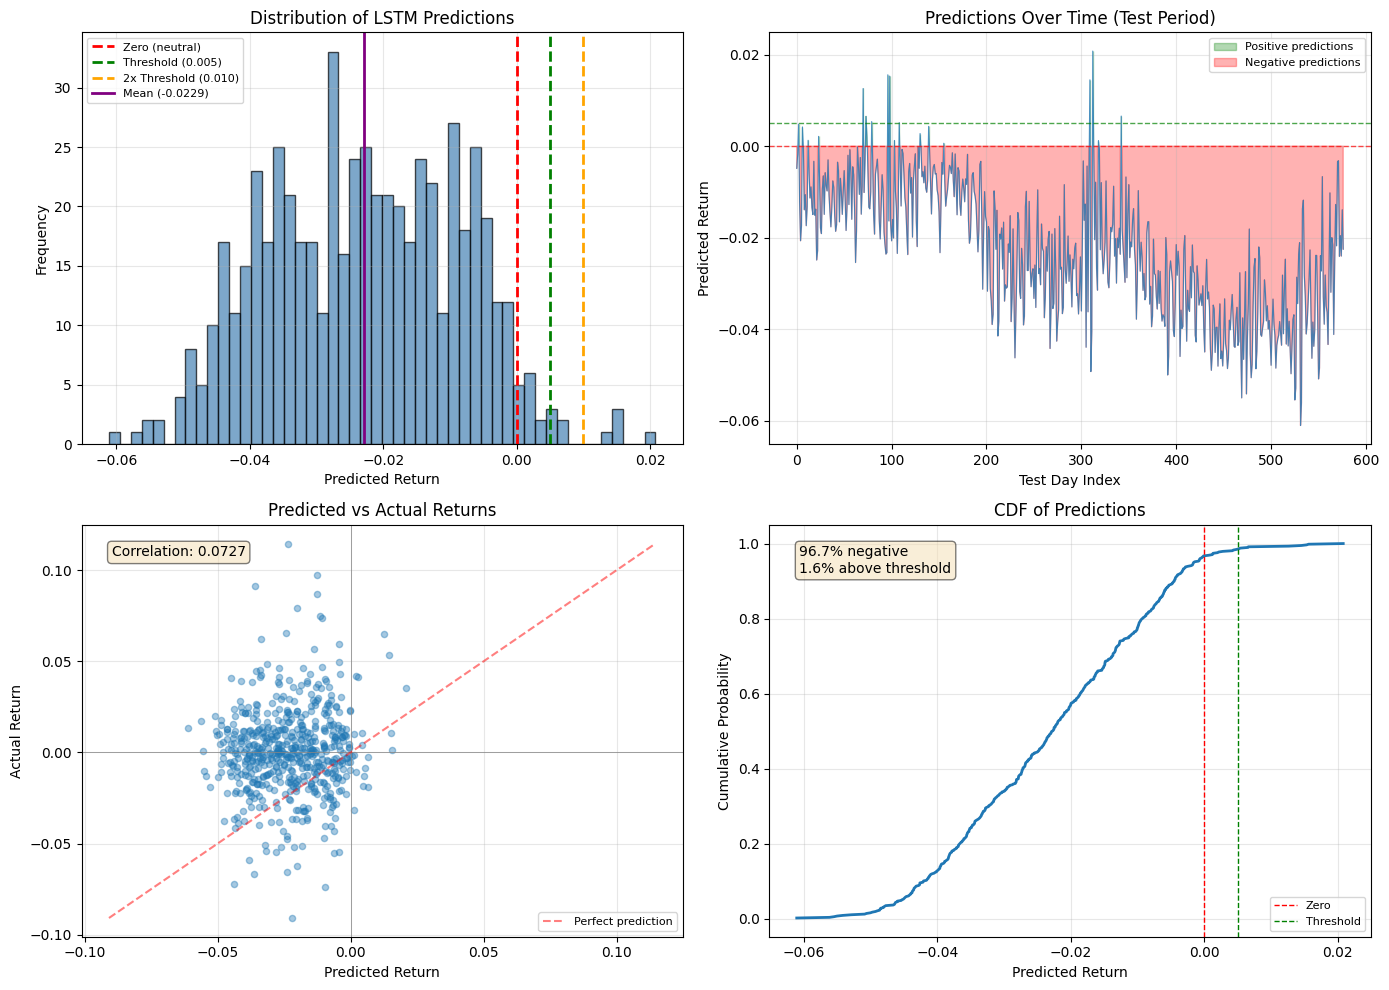


PREDICTION ANALYSIS SUMMARY

Prediction Distribution:
  Total predictions: 577
  Negative (w=0): 558 (96.7%)
  Positive but below threshold: 10 (1.7%)
  Above threshold: 9 (1.6%)
  Above 2x threshold (w=2): 5 (0.9%)

Correlation with actual returns: 0.0727


In [105]:
# =============================================================================
# ANALYZE RAW LSTM PREDICTIONS DISTRIBUTION
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of predictions
ax1 = axes[0, 0]
ax1.hist(predictions, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero (neutral)')
ax1.axvline(x=THRESHOLD_HIGH, color='green', linestyle='--', linewidth=2, label=f'Threshold ({THRESHOLD_HIGH:.3f})')
ax1.axvline(x=2*THRESHOLD_HIGH, color='orange', linestyle='--', linewidth=2, label=f'2x Threshold ({2*THRESHOLD_HIGH:.3f})')
ax1.axvline(x=predictions.mean(), color='purple', linestyle='-', linewidth=2, label=f'Mean ({predictions.mean():.4f})')
ax1.set_xlabel('Predicted Return')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of LSTM Predictions')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# 2. Predictions over time
ax2 = axes[0, 1]
ax2.plot(range(len(predictions)), predictions, linewidth=0.8, alpha=0.8)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
ax2.axhline(y=THRESHOLD_HIGH, color='green', linestyle='--', linewidth=1, alpha=0.7)
ax2.fill_between(range(len(predictions)), 0, predictions, where=(predictions > 0), 
                  color='green', alpha=0.3, label='Positive predictions')
ax2.fill_between(range(len(predictions)), 0, predictions, where=(predictions <= 0), 
                  color='red', alpha=0.3, label='Negative predictions')
ax2.set_xlabel('Test Day Index')
ax2.set_ylabel('Predicted Return')
ax2.set_title('Predictions Over Time (Test Period)')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# 3. Prediction vs Actual scatter
ax3 = axes[1, 0]
actual = backtest_metadata['actual_returns'][:len(predictions)]
ax3.scatter(predictions, actual, alpha=0.4, s=20)
ax3.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax3.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
# Add diagonal line for perfect predictions
lims = [min(predictions.min(), actual.min()), max(predictions.max(), actual.max())]
ax3.plot(lims, lims, 'r--', alpha=0.5, label='Perfect prediction')
ax3.set_xlabel('Predicted Return')
ax3.set_ylabel('Actual Return')
ax3.set_title('Predicted vs Actual Returns')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# Calculate correlation
corr = np.corrcoef(predictions, actual)[0, 1]
ax3.text(0.05, 0.95, f'Correlation: {corr:.4f}', transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Cumulative distribution of predictions
ax4 = axes[1, 1]
sorted_preds = np.sort(predictions)
cumulative = np.arange(1, len(sorted_preds) + 1) / len(sorted_preds)
ax4.plot(sorted_preds, cumulative, linewidth=2)
ax4.axvline(x=0, color='red', linestyle='--', linewidth=1, label='Zero')
ax4.axvline(x=THRESHOLD_HIGH, color='green', linestyle='--', linewidth=1, label=f'Threshold')
# Add annotations for key percentiles
pct_negative = (predictions <= 0).mean() * 100
pct_above_threshold = (predictions > THRESHOLD_HIGH).mean() * 100
ax4.set_xlabel('Predicted Return')
ax4.set_ylabel('Cumulative Probability')
ax4.set_title('CDF of Predictions')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)
ax4.text(0.05, 0.95, f'{pct_negative:.1f}% negative\n{pct_above_threshold:.1f}% above threshold', 
         transform=ax4.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(os.path.join(REPORTS_DIR, 'prediction_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("PREDICTION ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nPrediction Distribution:")
print(f"  Total predictions: {len(predictions)}")
print(f"  Negative (w=0): {(predictions <= 0).sum()} ({pct_negative:.1f}%)")
print(f"  Positive but below threshold: {((predictions > 0) & (predictions <= THRESHOLD_HIGH)).sum()} ({((predictions > 0) & (predictions <= THRESHOLD_HIGH)).mean()*100:.1f}%)")
print(f"  Above threshold: {(predictions > THRESHOLD_HIGH).sum()} ({pct_above_threshold:.1f}%)")
print(f"  Above 2x threshold (w=2): {(predictions > 2*THRESHOLD_HIGH).sum()} ({(predictions > 2*THRESHOLD_HIGH).mean()*100:.1f}%)")
print(f"\nCorrelation with actual returns: {corr:.4f}")

In [106]:
# =============================================================================
# CREATE BACKTEST DATAFRAME WITH RAW WEIGHTS
# =============================================================================

def prediction_to_weight(pred, threshold_high=THRESHOLD_HIGH, use_continuous=True):
    """
    Map predicted return to allocation weight using CONTINUOUS scaling.
    
    Args:
        pred: Predicted log return
        threshold_high: Threshold for maximum allocation (default 0.005 = 0.5%)
        use_continuous: If True, use continuous scaling; if False, use discrete {0,1,2}
    
    Returns:
        Weight in [0, 2]:
        - Continuous mode: w = clip(pred / threshold_high, 0, 2)
        - Discrete mode: {0, 1, 2} based on thresholds
    """
    if use_continuous:
        # Continuous scaling: linearly map predictions to weights
        # pred=0 -> w=0, pred=threshold -> w=1, pred=2*threshold -> w=2
        if pred <= 0:
            return 0.0
        else:
            # Linear scaling: w = pred / threshold, capped at 2
            return min(pred / threshold_high, 2.0)
    else:
        # Original discrete logic
        if pred <= 0:
            return 0.0
        elif pred <= threshold_high:
            return 1.0
        else:
            return 2.0

# Get test dates and actual returns (aligned with predictions)
test_dates = backtest_metadata['dates']
test_actual_returns = backtest_metadata['actual_returns']

# Create backtest dataframe
backtest_df = pd.DataFrame({
    'date': test_dates[:len(predictions)],
    'ret': test_actual_returns[:len(predictions)],  # True BTC log return
    'pred': predictions,
    'w_raw': [prediction_to_weight(p) for p in predictions]
})

# Calculate raw strategy returns
backtest_df['r_strat_raw'] = backtest_df['w_raw'] * backtest_df['ret']

# Benchmark returns (buy and hold BTC)
backtest_df['r_bench'] = backtest_df['ret']

print("Backtest DataFrame created:")
print(f"  Shape: {backtest_df.shape}")
print(f"  Date range: {backtest_df['date'].iloc[0]} to {backtest_df['date'].iloc[-1]}")
print(f"\nRaw weight distribution:")
print(f"  Mean weight: {backtest_df['w_raw'].mean():.4f}")
print(f"  Std weight: {backtest_df['w_raw'].std():.4f}")
print(f"  Days with w=0: {(backtest_df['w_raw'] == 0).sum()} ({(backtest_df['w_raw'] == 0).mean()*100:.1f}%)")
print(f"  Days with w>0: {(backtest_df['w_raw'] > 0).sum()} ({(backtest_df['w_raw'] > 0).mean()*100:.1f}%)")
print(f"\nWeight value counts (binned):")
bins = [0, 0.001, 0.5, 1.0, 1.5, 2.0]
labels = ['0', '0-0.5', '0.5-1', '1-1.5', '1.5-2']
backtest_df['w_bin'] = pd.cut(backtest_df['w_raw'], bins=bins, labels=labels, include_lowest=True)
print(backtest_df['w_bin'].value_counts().sort_index())

backtest_df.head(10)

Backtest DataFrame created:
  Shape: (577, 6)
  Date range: 2024-05-06 00:00:00 to 2025-12-03 00:00:00

Raw weight distribution:
  Mean weight: 0.0341
  Std weight: 0.2214
  Days with w=0: 558 (96.7%)
  Days with w>0: 19 (3.3%)

Weight value counts (binned):
w_bin
0        558
0-0.5      6
0.5-1      4
1-1.5      4
1.5-2      5
Name: count, dtype: int64


,date,ret,pred,w_raw,r_strat_raw,r_bench,w_bin
0,2024-05-06,-0.013667,-0.004844,0.000000,-0.000000,-0.013667,0
1,2024-05-07,-0.013182,-0.001746,0.000000,-0.000000,-0.013182,0
2,2024-05-08,-0.018570,0.004826,0.965148,-0.017923,-0.018570,0.5-1
3,2024-05-09,0.029977,-0.012118,0.000000,0.000000,0.029977,0
4,2024-05-10,-0.036456,-0.020689,0.000000,-0.000000,-0.036456,0
5,2024-05-11,0.000015,-0.017400,0.000000,0.000000,0.000015,0
6,2024-05-12,0.010711,0.004212,0.842412,0.009023,0.010711,0.5-1
7,2024-05-13,0.023371,-0.000339,0.000000,0.000000,0.023371,0
8,2024-05-14,-0.021674,-0.013915,0.000000,-0.000000,-0.021674,0
9,2024-05-15,0.073804,-0.010603,0.000000,0.000000,0.073804,0


In [107]:
# =============================================================================
# APPLY VOLATILITY CONSTRAINT
# =============================================================================

# Compute volatilities
vol_bench = backtest_df['r_bench'].std()
vol_strat_raw = backtest_df['r_strat_raw'].std()

print("=" * 60)
print("VOLATILITY CONSTRAINT")
print("=" * 60)
print(f"\nBenchmark volatility (daily): {vol_bench:.6f}")
print(f"Raw strategy volatility (daily): {vol_strat_raw:.6f}")
print(f"Volatility constraint: {VOL_CONSTRAINT}x benchmark = {VOL_CONSTRAINT * vol_bench:.6f}")

# Apply volatility scaling if needed
if vol_strat_raw <= VOL_CONSTRAINT * vol_bench:
    scale_factor = 1.0
    print(f"\n✓ Strategy volatility is within constraint")
    print(f"  Scale factor: {scale_factor:.4f} (no scaling needed)")
else:
    scale_factor = (VOL_CONSTRAINT * vol_bench) / vol_strat_raw
    print(f"\n⚠️  Strategy volatility EXCEEDS constraint")
    print(f"  Scale factor: {scale_factor:.4f} (weights will be reduced)")

# Apply scaling to weights
backtest_df['w'] = np.clip(backtest_df['w_raw'] * scale_factor, 0, 2)

# Calculate final strategy returns
backtest_df['r_strat'] = backtest_df['w'] * backtest_df['ret']

# Verify final volatility
vol_strat_final = backtest_df['r_strat'].std()
print(f"\nFinal strategy volatility: {vol_strat_final:.6f}")
print(f"Final volatility ratio: {vol_strat_final / vol_bench:.4f}")

# Weight statistics after scaling
print(f"\nFinal weight statistics:")
print(f"  Mean weight: {backtest_df['w'].mean():.4f}")
print(f"  Min weight: {backtest_df['w'].min():.4f}")
print(f"  Max weight: {backtest_df['w'].max():.4f}")

VOLATILITY CONSTRAINT

Benchmark volatility (daily): 0.023962
Raw strategy volatility (daily): 0.007891
Volatility constraint: 1.5x benchmark = 0.035944

✓ Strategy volatility is within constraint
  Scale factor: 1.0000 (no scaling needed)

Final strategy volatility: 0.007891
Final volatility ratio: 0.3293

Final weight statistics:
  Mean weight: 0.0341
  Min weight: 0.0000
  Max weight: 2.0000


In [108]:
# =============================================================================
# DEFINE METRIC FUNCTIONS
# =============================================================================

def cumulative_returns(returns):
    """
    Calculate cumulative returns curve.
    
    Args:
        returns: Array of daily returns
        
    Returns:
        Cumulative returns starting from 1.0
    """
    return (1 + returns).cumprod()


def calc_volatility(returns):
    """
    Calculate annualized volatility.
    
    Args:
        returns: Array of daily returns
        
    Returns:
        Annualized volatility (assuming 365 trading days for crypto)
    """
    return returns.std() * np.sqrt(365)


def sharpe_ratio(returns):
    """
    Calculate Sharpe ratio (assuming risk-free rate = 0).
    
    Args:
        returns: Array of daily returns
        
    Returns:
        Annualized Sharpe ratio
    """
    if returns.std() == 0:
        return 0.0
    return (returns.mean() / returns.std()) * np.sqrt(365)


def max_drawdown(cum_returns):
    """
    Calculate maximum drawdown from cumulative returns curve.
    
    Args:
        cum_returns: Cumulative returns curve
        
    Returns:
        Maximum drawdown (negative value)
    """
    running_max = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - running_max) / running_max
    return drawdown.min()

print("Metric functions defined:"
      "\n  - cumulative_returns()"
      "\n  - calc_volatility()"
      "\n  - sharpe_ratio()"
      "\n  - max_drawdown()")

Metric functions defined:
  - cumulative_returns()
  - calc_volatility()
  - sharpe_ratio()
  - max_drawdown()


In [109]:
# =============================================================================
# COMPUTE PERFORMANCE METRICS
# =============================================================================

# Calculate cumulative returns
backtest_df['cum_strat'] = cumulative_returns(backtest_df['r_strat'].values)
backtest_df['cum_bench'] = cumulative_returns(backtest_df['r_bench'].values)

# Strategy metrics
strat_total_return = (backtest_df['cum_strat'].iloc[-1] - 1) * 100
strat_volatility = calc_volatility(backtest_df['r_strat'].values)
strat_sharpe = sharpe_ratio(backtest_df['r_strat'].values)
strat_max_dd = max_drawdown(backtest_df['cum_strat'].values) * 100

# Benchmark metrics
bench_total_return = (backtest_df['cum_bench'].iloc[-1] - 1) * 100
bench_volatility = calc_volatility(backtest_df['r_bench'].values)
bench_sharpe = sharpe_ratio(backtest_df['r_bench'].values)
bench_max_dd = max_drawdown(backtest_df['cum_bench'].values) * 100

# Volatility ratio
vol_ratio = strat_volatility / bench_volatility

print("=" * 70)
print("PERFORMANCE METRICS SUMMARY")
print("=" * 70)
print(f"\n{'Metric':<30} {'Strategy':>15} {'Benchmark (BTC)':>15}")
print("-" * 70)
print(f"{'Total Return (%)':<30} {strat_total_return:>15.2f} {bench_total_return:>15.2f}")
print(f"{'Annualized Volatility (%)':<30} {strat_volatility*100:>15.2f} {bench_volatility*100:>15.2f}")
print(f"{'Sharpe Ratio':<30} {strat_sharpe:>15.4f} {bench_sharpe:>15.4f}")
print(f"{'Max Drawdown (%)':<30} {strat_max_dd:>15.2f} {bench_max_dd:>15.2f}")
print(f"{'Volatility Ratio':<30} {vol_ratio:>15.4f} {'-':>15}")
print("-" * 70)

# Performance comparison
print(f"\nPerformance vs Benchmark:")
if strat_total_return > bench_total_return:
    print(f"  ✓ Strategy OUTPERFORMS by {strat_total_return - bench_total_return:.2f}%")
else:
    print(f"  ⚠️  Strategy underperforms by {bench_total_return - strat_total_return:.2f}%")
    
if strat_sharpe > bench_sharpe:
    print(f"  ✓ Better risk-adjusted returns (Sharpe: {strat_sharpe:.4f} vs {bench_sharpe:.4f})")
else:
    print(f"  ⚠️  Lower risk-adjusted returns (Sharpe: {strat_sharpe:.4f} vs {bench_sharpe:.4f})")

if vol_ratio <= VOL_CONSTRAINT:
    print(f"  ✓ Volatility constraint satisfied ({vol_ratio:.4f} <= {VOL_CONSTRAINT})")
else:
    print(f"  ⚠️  Volatility constraint violated ({vol_ratio:.4f} > {VOL_CONSTRAINT})")

PERFORMANCE METRICS SUMMARY

Metric                                Strategy Benchmark (BTC)
----------------------------------------------------------------------
Total Return (%)                         33.34           23.26
Annualized Volatility (%)                15.06           45.74
Sharpe Ratio                            1.2790          0.5168
Max Drawdown (%)                         -3.23          -33.12
Volatility Ratio                        0.3293               -
----------------------------------------------------------------------

Performance vs Benchmark:
  ✓ Strategy OUTPERFORMS by 10.08%
  ✓ Better risk-adjusted returns (Sharpe: 1.2790 vs 0.5168)
  ✓ Volatility constraint satisfied (0.3293 <= 1.5)


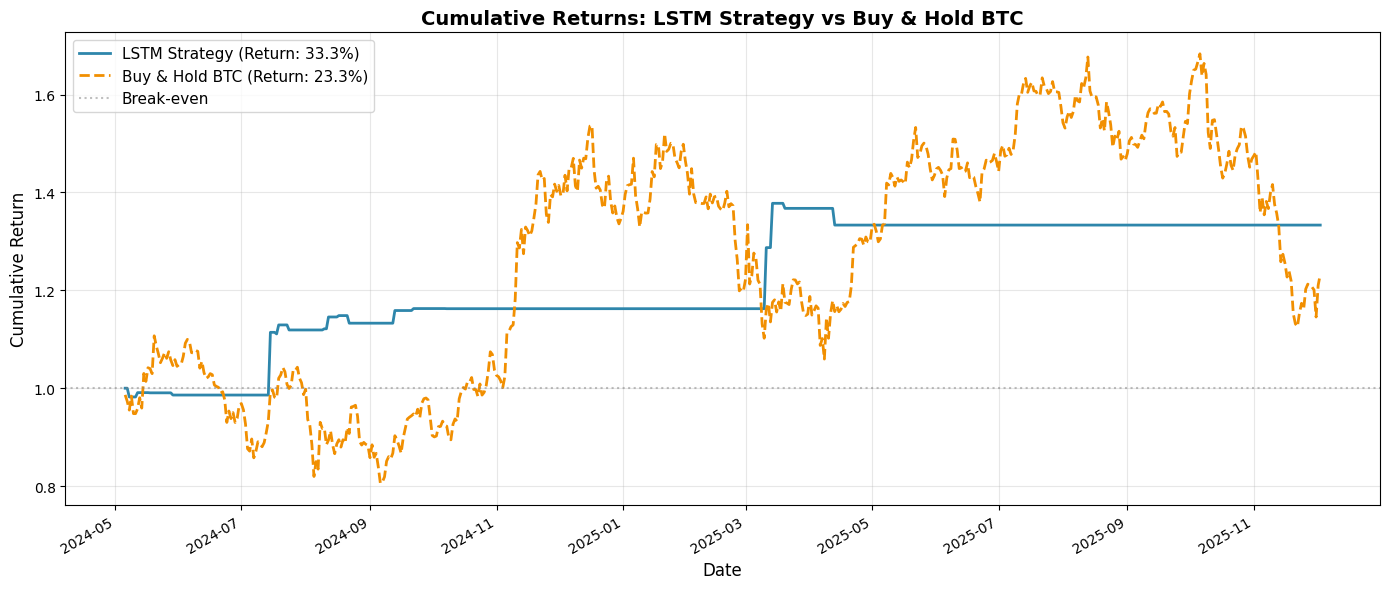


Cumulative returns plot saved to: /Users/erikp/Documents/vscode/HullTactical/HullTactical/extension/notebooks/../reports/cum_returns.png


In [110]:
# =============================================================================
# PLOT 1: CUMULATIVE RETURNS - STRATEGY VS BENCHMARK
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 6))

# Convert dates for plotting
plot_dates = pd.to_datetime(backtest_df['date'])

ax.plot(plot_dates, backtest_df['cum_strat'], 
        label=f'LSTM Strategy (Return: {strat_total_return:.1f}%)', 
        linewidth=2, color='#2E86AB')
ax.plot(plot_dates, backtest_df['cum_bench'], 
        label=f'Buy & Hold BTC (Return: {bench_total_return:.1f}%)', 
        linewidth=2, color='#F18F01', linestyle='--')

ax.axhline(y=1.0, color='gray', linestyle=':', alpha=0.5, label='Break-even')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Return', fontsize=12)
ax.set_title('Cumulative Returns: LSTM Strategy vs Buy & Hold BTC', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

# Format x-axis dates
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.savefig(CUM_RETURNS_PLOT_PATH, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nCumulative returns plot saved to: {CUM_RETURNS_PLOT_PATH}")

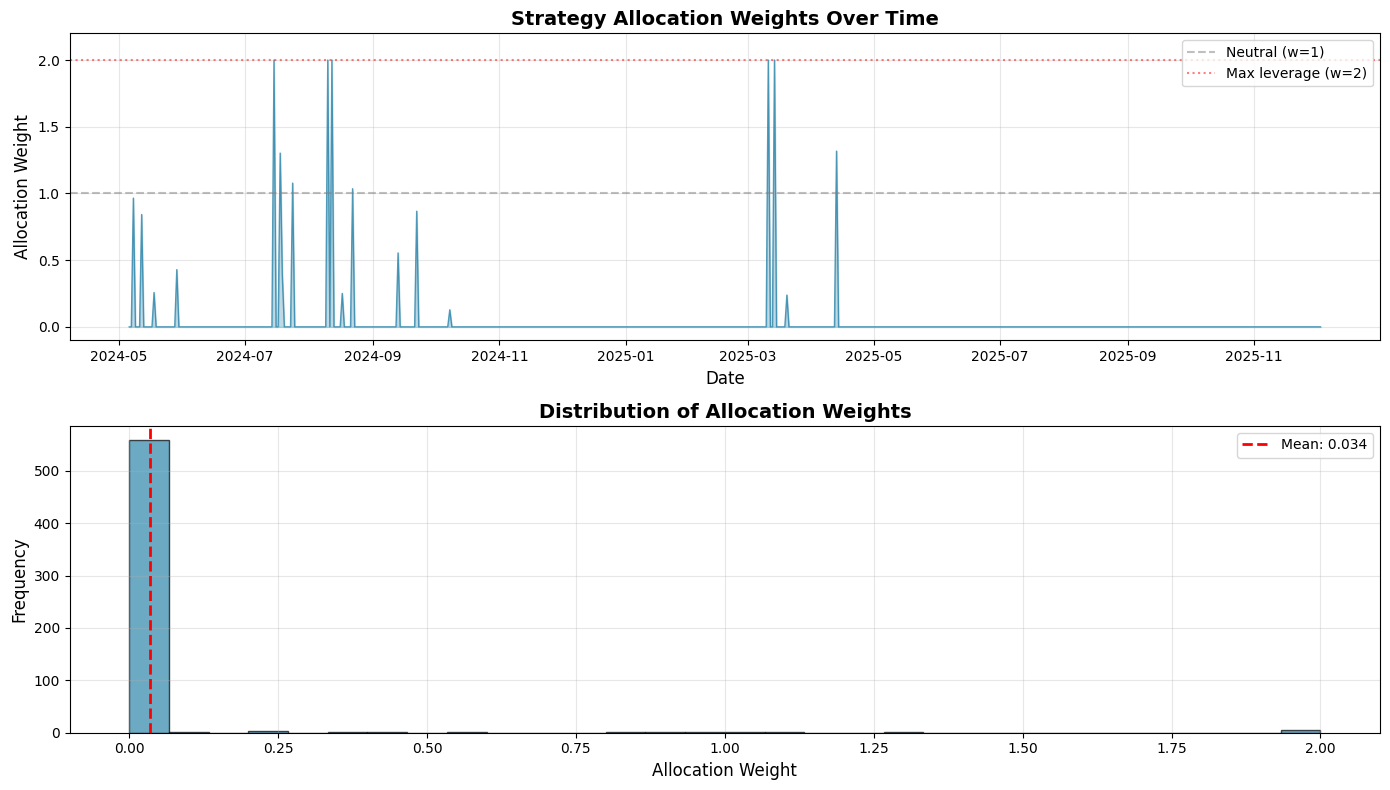


Weights plot saved to: /Users/erikp/Documents/vscode/HullTactical/HullTactical/extension/notebooks/../reports/weights.png


In [111]:
# =============================================================================
# PLOT 2: STRATEGY WEIGHTS OVER TIME
# =============================================================================

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Weights over time
ax1 = axes[0]
ax1.plot(plot_dates, backtest_df['w'], linewidth=1, color='#2E86AB', alpha=0.8)
ax1.fill_between(plot_dates, 0, backtest_df['w'], alpha=0.3, color='#2E86AB')
ax1.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Neutral (w=1)')
ax1.axhline(y=2.0, color='red', linestyle=':', alpha=0.5, label='Max leverage (w=2)')

ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Allocation Weight', fontsize=12)
ax1.set_title('Strategy Allocation Weights Over Time', fontsize=14, fontweight='bold')
ax1.set_ylim(-0.1, 2.2)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Weight distribution histogram
ax2 = axes[1]
ax2.hist(backtest_df['w'], bins=30, edgecolor='black', alpha=0.7, color='#2E86AB')
ax2.axvline(x=backtest_df['w'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {backtest_df["w"].mean():.3f}')
ax2.set_xlabel('Allocation Weight', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Allocation Weights', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(WEIGHTS_PLOT_PATH, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nWeights plot saved to: {WEIGHTS_PLOT_PATH}")

### Backtest Results Summary

Final performance metrics and comparison between the LSTM strategy and buy-and-hold BTC benchmark.

In [ ]:
# =============================================================================
# FINAL RESULTS SUMMARY
# =============================================================================

# Create results summary dataframe
results_summary = pd.DataFrame({
    'Metric': [
        'Total Return (%)',
        'Annualized Volatility (%)',
        'Sharpe Ratio',
        'Max Drawdown (%)',
        'Volatility Ratio',
        'Mean Allocation Weight',
        'Test Period Days'
    ],
    'Strategy': [
        f"{strat_total_return:.2f}",
        f"{strat_volatility*100:.2f}",
        f"{strat_sharpe:.4f}",
        f"{strat_max_dd:.2f}",
        f"{vol_ratio:.4f}",
        f"{backtest_df['w'].mean():.4f}",
        f"{len(backtest_df)}"
    ],
    'Benchmark (BTC)': [
        f"{bench_total_return:.2f}",
        f"{bench_volatility*100:.2f}",
        f"{bench_sharpe:.4f}",
        f"{bench_max_dd:.2f}",
        "-",
        "1.0000",
        f"{len(backtest_df)}"
    ]
})

print("=" * 70)
print("FINAL BACKTEST RESULTS")
print("=" * 70)
print(f"\nTest Period: {backtest_df['date'].iloc[0]} to {backtest_df['date'].iloc[-1]}")
print(f"Number of trading days: {len(backtest_df)}") 
print()
display(results_summary.set_index('Metric'))

print("\n" + "=" * 70)
print("STEP 6 COMPLETE: Backtesting finished")
print("=" * 70)
print(f"\nPlots saved to:")
print(f"  - {CUM_RETURNS_PLOT_PATH}")
print(f"  - {WEIGHTS_PLOT_PATH}")

FINAL BACKTEST RESULTS

Test Period: 2024-05-06 00:00:00 to 2025-12-03 00:00:00
Number of trading days: 577



,Strategy,Benchmark (BTC)
Metric,,
Total Return (%),33.34,23.26
Annualized Volatility (%),15.06,45.74
Sharpe Ratio,1.2790,0.5168
Max Drawdown (%),-3.23,-33.12
Volatility Ratio,0.3293,-
Mean Allocation Weight,0.0341,1.0000
Test Period Days,577,577



STEP 6 COMPLETE: Backtesting finished

Plots saved to:
  - /Users/erikp/Documents/vscode/HullTactical/HullTactical/extension/notebooks/../reports/cum_returns.png
  - /Users/erikp/Documents/vscode/HullTactical/HullTactical/extension/notebooks/../reports/weights.png


## Project Structure

```
extension/
├── data/
│   ├── btc_raw.csv          # Raw data from yfinance
│   ├── btc_daily.csv        # Cleaned daily data with log returns
│   └── btc_features.csv     # Feature-engineered dataset
├── notebooks/
│   └── 01_btc_crypto_extension.ipynb   # This notebook
├── reports/
│   ├── dataset_card.md      # Dataset documentation
│   ├── appendix_crypto_extension.md  # Model & strategy appendix
│   ├── cum_returns.png      # Cumulative returns plot
│   └── weights.png          # Strategy weights plot
├── README.md                # Project readme
└── requirements.txt         # Python dependencies
```